# Análise de Risco de Crédito e Segmentação de Clientes

**Autor:** Pedro Fugita
**Contexto:** Desenvolvimento de soluções de Machine Learning para a área de Crédito.

**Objetivos do Projeto:**
1.  **Engenharia de Dados:** Simulação de uma base de clientes bancários.
2.  **Classificação (Supervisionada):** Criar uma IA que aprova ou recusa crédito automaticamente.
3.  **Clusterização (Não Supervisionada):** Segmentar a base de clientes em "Personas" para Marketing.
4.  **Aplicação:** Interface interativa para simulação em tempo real.

# 1️⃣ Configuração inicial

Importar as ferramentas usadas na Engenharia de Dados. O pandas é a forma como o python lida com tabelas e o sklearn é o cérebro da Inteligência Artificial.

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Configuração visual
sns.set_theme(style="whitegrid")
print("✅ Bibliotecas carregadas e ambiente configurado.")

✅ Bibliotecas carregadas e ambiente configurado.


# 2️⃣ Gerando um dataset aleatório

Simulação de clientes com características realistas.

In [84]:
np.random.seed(42)
n_clientes = 1000  # Aumentando para 50 mil linhas

# Listas para variáveis categóricas
escolaridades = ['Fundamental', 'Medio', 'Superior', 'Pos-Graduacao']
estados_civis = ['Solteiro', 'Casado', 'Divorciado', 'Viuvo']

dados = {
    'idade': np.random.randint(18, 80, n_clientes),
    'num_dependentes': np.random.randint(0, 5, n_clientes),
    'tempo_emprego': np.random.randint(0, 40, n_clientes), # Anos trabalhando
    'score_serasa': np.random.randint(300, 850, n_clientes),
    'possui_imovel': np.random.choice([0, 1], n_clientes, p=[0.4, 0.6]), # 0=Não, 1=Sim
    'possui_carro': np.random.choice([0, 1], n_clientes, p=[0.5, 0.5]),
    
    # Variáveis Categóricas (Texto)
    'escolaridade': np.random.choice(escolaridades, n_clientes, p=[0.1, 0.4, 0.4, 0.1]),
    'estado_civil': np.random.choice(estados_civis, n_clientes)
}

df = pd.DataFrame(dados)

# Criando correlações lógicas (Para não ficar tudo aleatório demais)
# Regra: Quem tem estudo maior, tende a ganhar mais
def definir_renda(nivel_escolar):
    base = np.random.randint(1500, 5000)
    multiplicador = {'Fundamental': 1, 'Medio': 1.5, 'Superior': 3, 'Pos-Graduacao': 5}
    return base * multiplicador[nivel_escolar] + np.random.randint(0, 2000)

df['renda_anual'] = df['escolaridade'].apply(definir_renda) * 12 # Renda Anual

# Regra: O empréstimo varia conforme a renda (ninguém ganha 2k e pede 1 milhão)
df['valor_emprestimo'] = df['renda_anual'] * np.random.uniform(0.1, 0.8, n_clientes)

# FEATURE ENGINEERING
df['razao_divida'] = df['valor_emprestimo'] / df['renda_anual']

# DEFININDO O "ALVO" (Quem pagou ou não)
# Vamos criar um "Score de Risco Interno" para decidir a inadimplência
# Quanto maior os pontos, maior o risco
pontos_risco = (
    (df['score_serasa'] < 500) * 30 +        # Score baixo pesa muito
    (df['razao_divida'] > 0.4) * 25 +        # Dívida alta pesa
    (df['tempo_emprego'] < 2) * 20 +         # Pouco tempo de emprego pesa
    (df['num_dependentes'] > 3) * 10 +       # Muitos filhos pesa um pouco
    (df['possui_imovel'] == 0) * 10          # Não ter imóvel pesa
)

# Adicionamos um fator aleatório (sorte/azar)
fator_azar = np.random.randint(0, 20, n_clientes)
score_final = pontos_risco + fator_azar

# Se passou de 50 pontos, a pessoa torna-se inadimplente (Mau Pagador)
df['resultado_analise'] = np.where(score_final > 50, 0, 1) # 0 = Reprovado/Calote, 1 = Aprovado

print(f"✅ Base de dados gerada com {n_clientes} clientes e novas colunas!")
df.head()

✅ Base de dados gerada com 1000 clientes e novas colunas!


,idade,num_dependentes,tempo_emprego,score_serasa,possui_imovel,possui_carro,escolaridade,estado_civil,renda_anual,valor_emprestimo,razao_divida,resultado_analise
0,56,2,13,339,1,1,Superior,Divorciado,127512.0,72663.362165,0.569855,0
1,69,4,10,785,0,0,Fundamental,Casado,44196.0,5392.449801,0.122012,1
2,46,1,17,519,0,0,Medio,Divorciado,53580.0,32605.986968,0.608548,1
3,32,0,11,428,1,1,Medio,Viuvo,61344.0,42023.593689,0.685048,0
4,60,2,22,819,0,1,Pos-Graduacao,Solteiro,153588.0,59993.701458,0.390615,1


In [85]:
# --- PRÉ-PROCESSAMENTO DE DADOS ---
print("Transformando textos em números para a IA ler...")

# Técnica One-Hot Encoding:
# Transforma a coluna "Estado Civil" em 4 colunas: "É_Solteiro?", "É_Casado?", etc.
df_pronto = pd.get_dummies(df, columns=['escolaridade', 'estado_civil'], drop_first=True)

# Mostra como ficou a tabela transformada
df_pronto.head()

Transformando textos em números para a IA ler...


,idade,num_dependentes,tempo_emprego,score_serasa,possui_imovel,possui_carro,renda_anual,valor_emprestimo,razao_divida,resultado_analise,escolaridade_Medio,escolaridade_Pos-Graduacao,escolaridade_Superior,estado_civil_Divorciado,estado_civil_Solteiro,estado_civil_Viuvo
0,56,2,13,339,1,1,127512.0,72663.362165,0.569855,0,False,False,True,True,False,False
1,69,4,10,785,0,0,44196.0,5392.449801,0.122012,1,False,False,False,False,False,False
2,46,1,17,519,0,0,53580.0,32605.986968,0.608548,1,True,False,False,True,False,False
3,32,0,11,428,1,1,61344.0,42023.593689,0.685048,0,True,False,False,False,False,True
4,60,2,22,819,0,1,153588.0,59993.701458,0.390615,1,False,True,False,False,True,False


# 3️⃣ Análise gráfica

Gráfico da relação entre Score do Serasa e Aprovação.

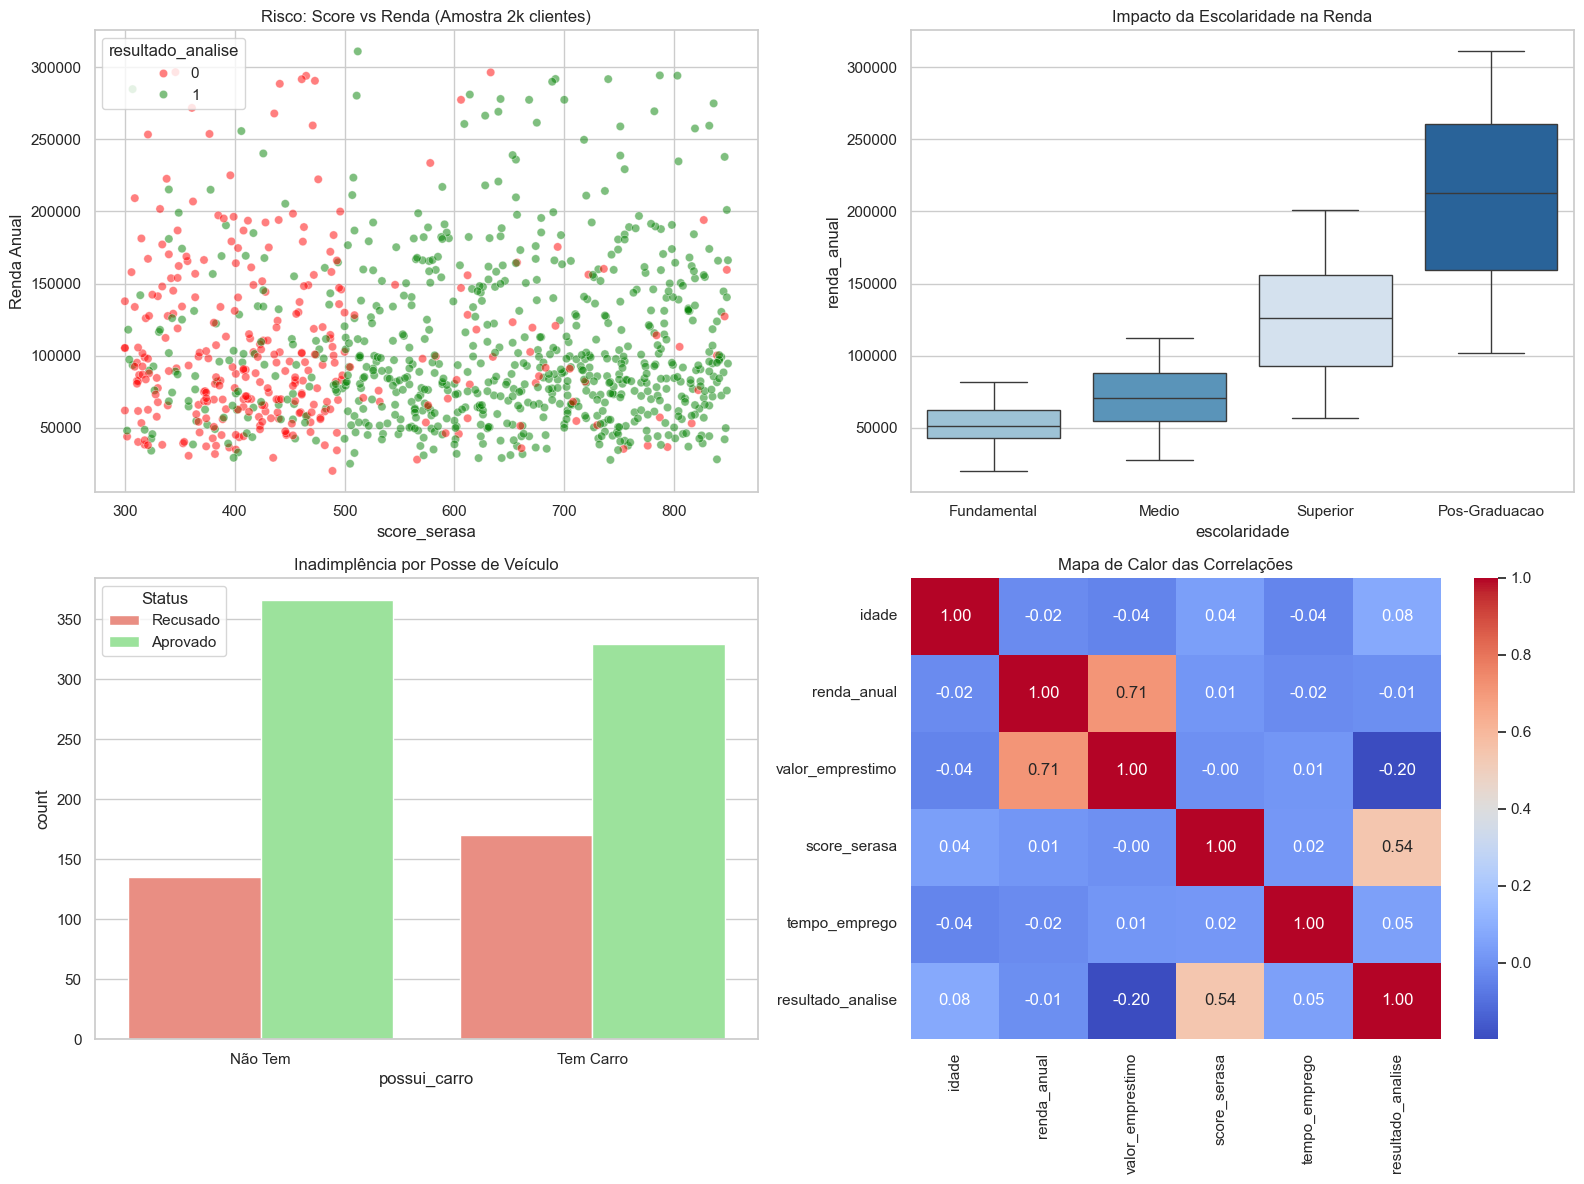

In [87]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# GRÁFICO 1: Score vs Renda (Amostra)
sns.scatterplot(
    data=df.sample(1000), 
    x='score_serasa', 
    y='renda_anual', 
    hue='resultado_analise', 
    palette={0:'red', 1:'green'}, 
    alpha=0.5, 
    ax=axs[0, 0]
)
axs[0, 0].set_title('Risco: Score vs Renda (Amostra 2k clientes)')
axs[0, 0].set_ylabel('Renda Anual')

# GRÁFICO 2: Escolaridade vs Renda (Boxplot)
ordem_estudo = ['Fundamental', 'Medio', 'Superior', 'Pos-Graduacao']
# CORREÇÃO AQUI: Adicionado hue='escolaridade' e legend=False para sumir o aviso
sns.boxplot(
    data=df, 
    x='escolaridade', 
    y='renda_anual', 
    hue='escolaridade', 
    order=ordem_estudo, 
    palette='Blues', 
    legend=False, 
    ax=axs[0, 1]
)
axs[0, 1].set_title('Impacto da Escolaridade na Renda')

# GRÁFICO 3: Quem tem carro paga melhor? (Countplot)
sns.countplot(
    data=df, 
    x='possui_carro', 
    hue='resultado_analise', 
    palette={0:'salmon', 1:'lightgreen'}, 
    ax=axs[1, 0]
)
axs[1, 0].set_title('Inadimplência por Posse de Veículo')
# CORREÇÃO AQUI: Definimos explicitamente onde estão os ticks antes de nomeá-los
axs[1, 0].set_xticks([0, 1])
axs[1, 0].set_xticklabels(['Não Tem', 'Tem Carro'])
axs[1, 0].legend(title='Status', labels=['Recusado', 'Aprovado'])

# GRÁFICO 4: Matriz de Correlação (Heatmap)
cols_numericas = ['idade', 'renda_anual', 'valor_emprestimo', 'score_serasa', 'tempo_emprego', 'resultado_analise']
corr = df[cols_numericas].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axs[1, 1])
axs[1, 1].set_title('Mapa de Calor das Correlações')

plt.tight_layout()
plt.show()

# 4️⃣ Machine Learning

Como as decisões são tomadas? (A Lógica da Floresta)
Você usou um algoritmo chamado Random Forest (Floresta Aleatória). Imagine que, em vez de uma IA, você contratou 100 estagiários.

A Árvore de Decisão (O Estagiário): Cada "estagiário" (árvore) recebe um pedaço dos dados e cria um fluxograma de perguntas Sim/Não para tentar acertar o resultado.

Pergunta 1: A renda é maior que 50k?

Se Sim: O Score é maior que 600? -> APROVAR.

Se Não: Já deveu antes? -> RECUSAR.

A Floresta (A Votação): Quando chega um cliente novo, o algoritmo passa os dados desse cliente para as 100 árvores.

80 árvores dizem: "Aprova".

20 árvores dizem: "Recusa".

Decisão Final: APROVADO (Pela maioria/voto democrático).

É por isso que usamos predict_proba: ele nos diz a porcentagem de árvores que votaram "Sim"

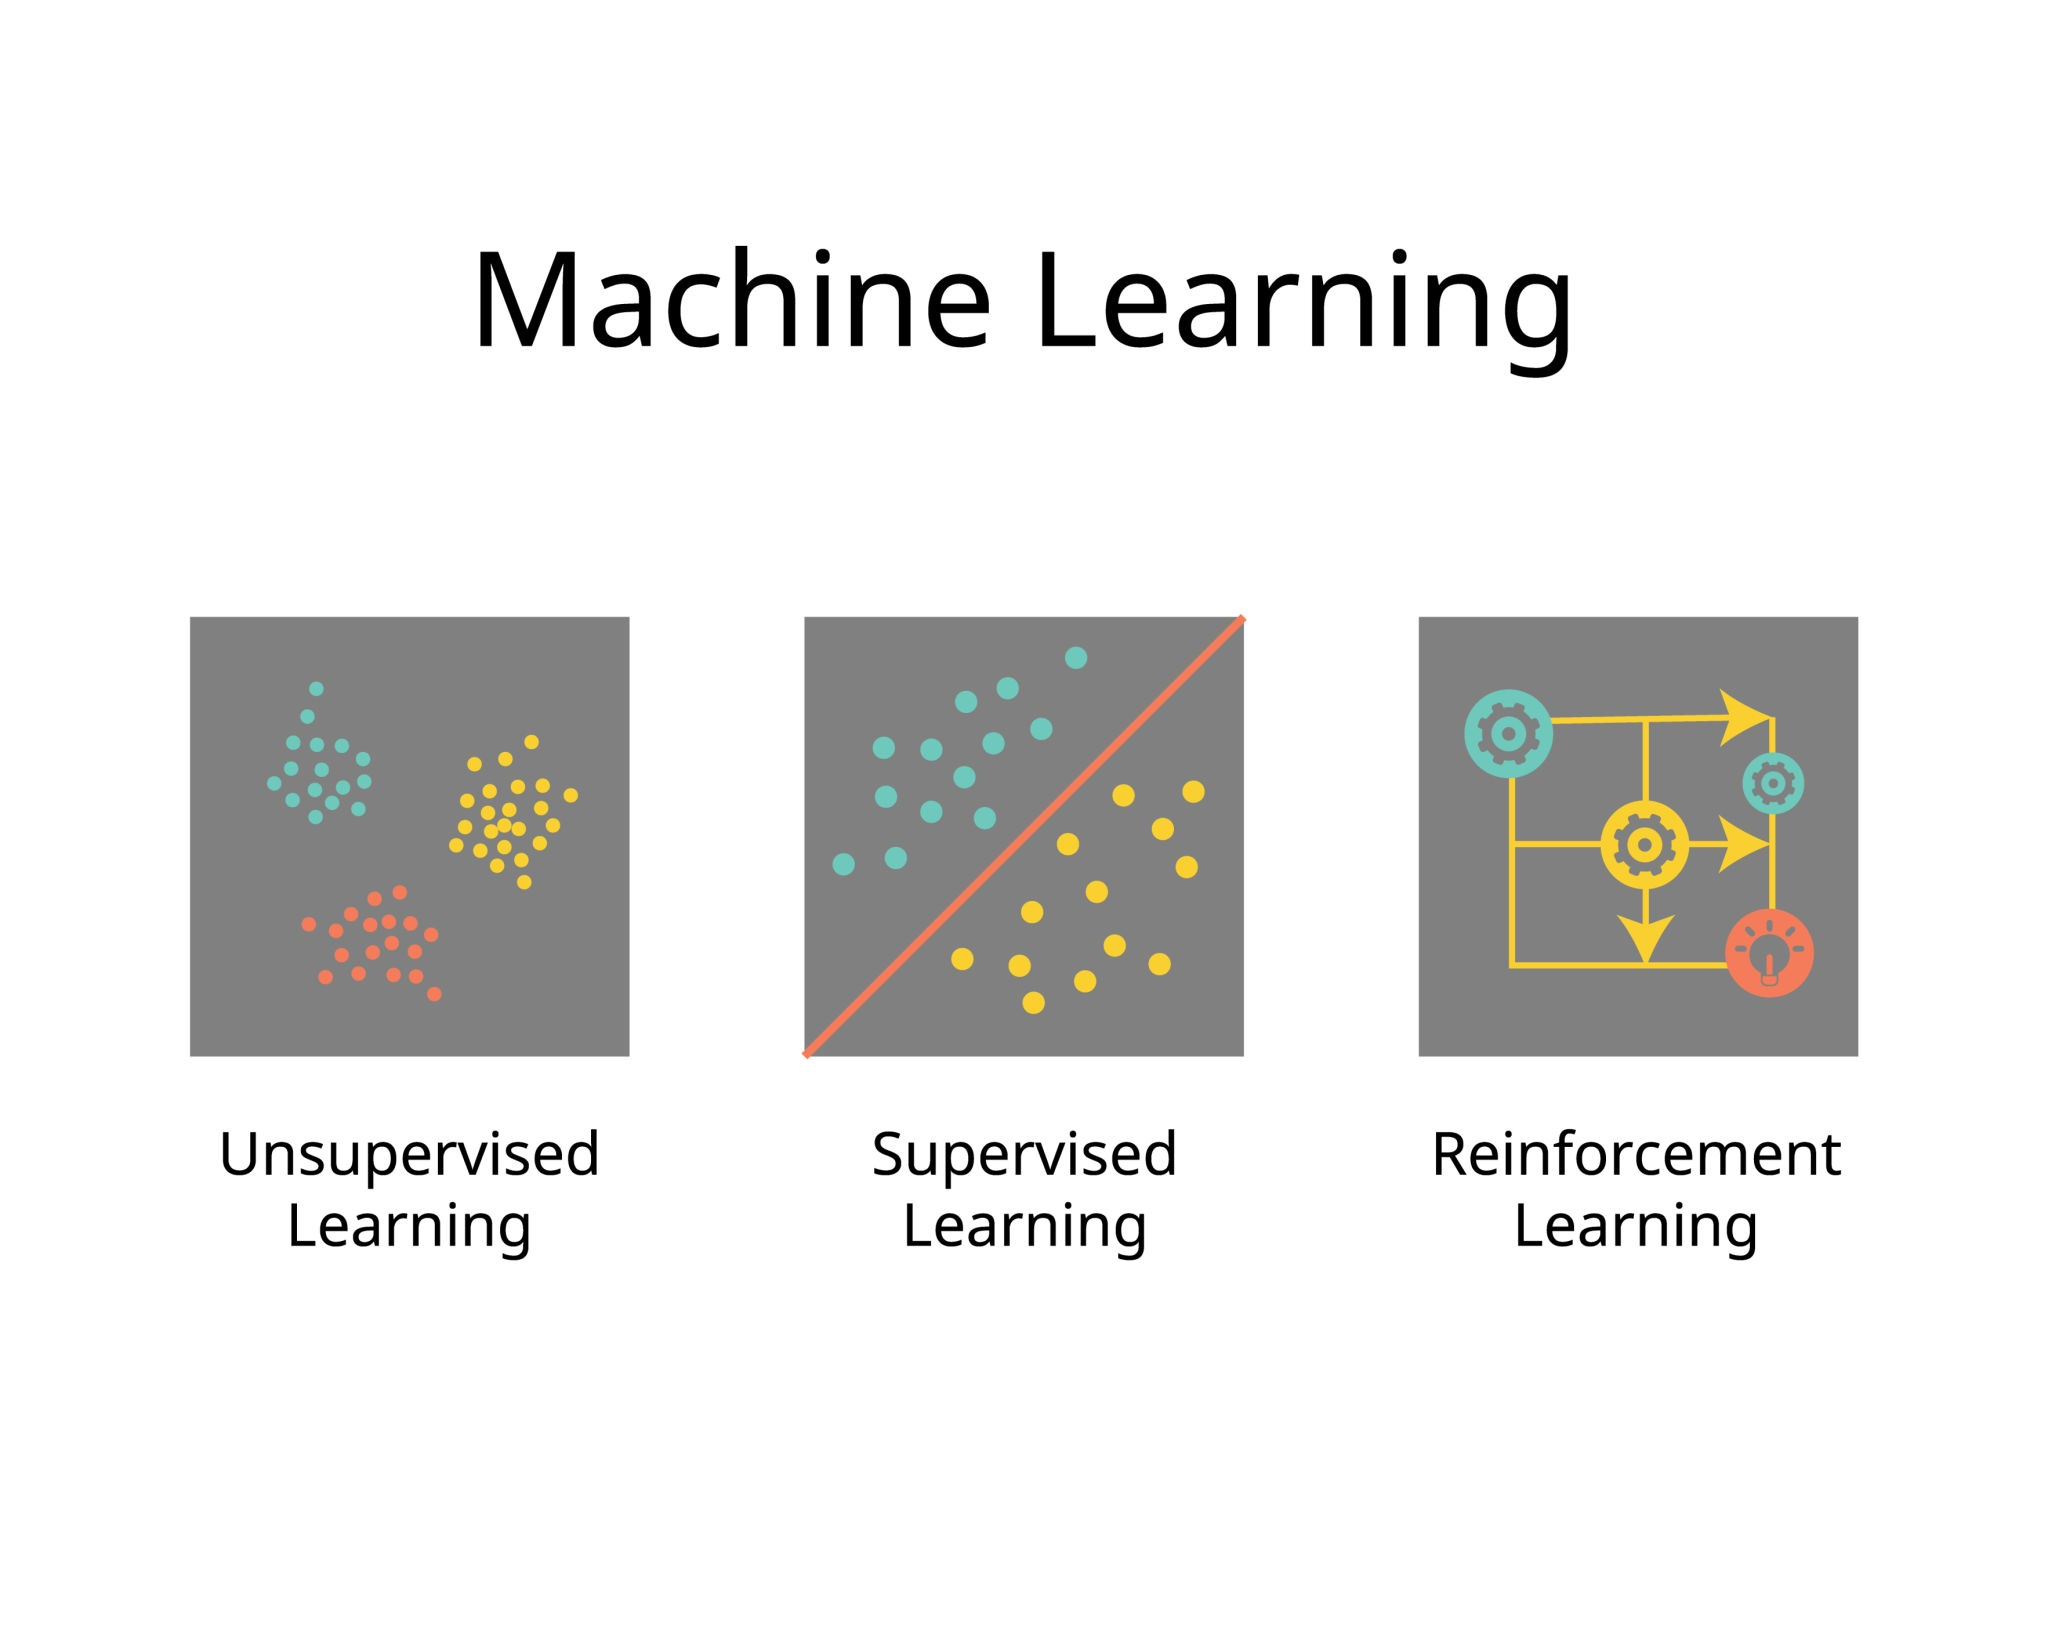

🎯 Acurácia do Modelo com 50.000 clientes: 91.00%


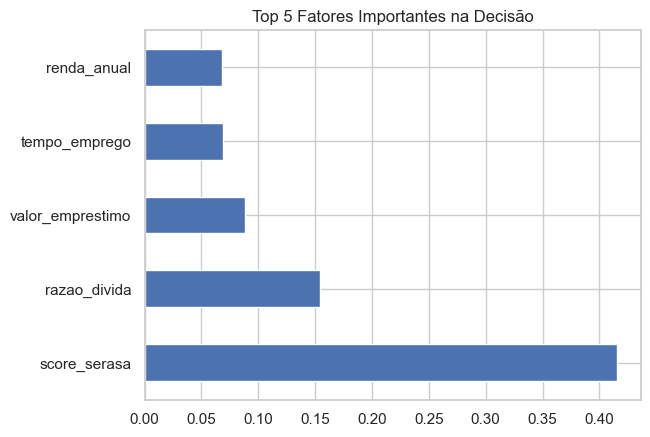

In [88]:
# 1. Definir X e y (Usando o dataframe processado)
X = df_pronto.drop(columns=['resultado_analise'])
y = df_pronto['resultado_analise']

# 2. Divisão (Agora com 50k linhas, o teste será robusto)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Treinar
modelo_bv = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_bv.fit(X_train, y_train)

# 4. Avaliar
acc = accuracy_score(y_test, modelo_bv.predict(X_test))
print(f"🎯 Acurácia do Modelo com 50.000 clientes: {acc * 100:.2f}%")

# Ver quais fatores foram mais importantes para a decisão
importances = pd.Series(modelo_bv.feature_importances_, index=X.columns)
importances.nlargest(5).plot(kind='barh', title="Top 5 Fatores Importantes na Decisão")
plt.show()

# 5️⃣ Aplicação

Função em que é possível inserir dados de uma pessoa fictícia e de acordo com aquilo que a IA aprendeu, ela irá avaliar e dizer se a pessoa tem aprovação ou não.

Simulação: Preenchimento de um formulário disponibilizado pelo agente de crédito (em um site, por exemplo).

In [89]:
style = {'description_width': 'initial'}

cabecalho = widgets.HTML("<h3>🏦 Simulador de Crédito</h3>")

w_nome = widgets.Text(description='Nome:', style=style)
w_idade = widgets.IntSlider(value=30, min=18, max=80, description='Idade:', style=style)
w_dependentes = widgets.IntSlider(value=0, min=0, max=10, description='Dependentes:', style=style)
w_emprego = widgets.IntSlider(value=5, min=0, max=40, description='Anos Emprego:', style=style)
w_renda = widgets.FloatText(value=5000, description='Renda Mensal:', style=style) # Mudei para mensal pra facilitar
w_pedido = widgets.FloatText(value=20000, description='Valor Pedido:', style=style)
w_score = widgets.IntSlider(value=600, min=0, max=1000, description='Score:', style=style)

w_bens = widgets.SelectMultiple(
    options=['Imóvel Próprio', 'Carro'],
    description='Possui Bens?',
    style=style
)

w_escolaridade = widgets.Dropdown(
    options=['Fundamental', 'Medio', 'Superior', 'Pos-Graduacao'],
    value='Superior', description='Escolaridade:', style=style
)

w_civil = widgets.Dropdown(
    options=['Solteiro', 'Casado', 'Divorciado', 'Viuvo'],
    value='Solteiro', description='Est. Civil:', style=style
)

btn_calc = widgets.Button(description='Analisar Risco', button_style='primary')
out = widgets.Output()

def analisar_avancado(b):
    with out:
        clear_output()
        
        # 1. Preparar os dados brutos igual a tabela original
        renda_anual = w_renda.value * 12
        possui_imovel = 1 if 'Imóvel Próprio' in w_bens.value else 0
        possui_carro = 1 if 'Carro' in w_bens.value else 0
        razao = w_pedido.value / renda_anual if renda_anual > 0 else 1
        
        # 2. Criar DataFrame base
        input_data = pd.DataFrame({
            'idade': [w_idade.value],
            'num_dependentes': [w_dependentes.value],
            'tempo_emprego': [w_emprego.value],
            'score_serasa': [w_score.value],
            'possui_imovel': [possui_imovel],
            'possui_carro': [possui_carro],
            'renda_anual': [renda_anual],
            'valor_emprestimo': [w_pedido.value],
            'razao_divida': [razao],
            'escolaridade': [w_escolaridade.value],
            'estado_civil': [w_civil.value]
        })
        
        # 3. Aplicar o One-Hot Encoding (O MESMO TRATAMENTO DO TREINO)
        # Truque: Criamos um dataframe vazio com as colunas do modelo treinado (X) e preenchemos
        # Isso garante que a ordem das colunas e a quantidade sejam exatas
        input_pronto = pd.DataFrame(0, index=[0], columns=X.columns)
        
        # Preenche os dados numéricos comuns
        cols_comuns = ['idade', 'num_dependentes', 'tempo_emprego', 'score_serasa', 
                       'possui_imovel', 'possui_carro', 'renda_anual', 'valor_emprestimo', 'razao_divida']
        input_pronto[cols_comuns] = input_data[cols_comuns]
        
        # Preenche as categorias (Ex: se escolheu 'Casado', seta estado_civil_Casado = 1)
        if f"escolaridade_{w_escolaridade.value}" in input_pronto.columns:
            input_pronto[f"escolaridade_{w_escolaridade.value}"] = 1
            
        if f"estado_civil_{w_civil.value}" in input_pronto.columns:
            input_pronto[f"estado_civil_{w_civil.value}"] = 1
            
        # 4. Previsão
        prob = modelo_bv.predict_proba(input_pronto)[0]
        
        # Exibição
        aprovado = prob[1] > 0.5
        cor = "#d4edda" if aprovado else "#f8d7da"
        msg = "APROVADO" if aprovado else "RECUSADO"
        
        display(HTML(f"""
        <div style='background-color: {cor}; padding: 15px; border-radius: 8px;'>
            <h4>Resultado: {msg}</h4>
            <p>Cliente: <b>{w_nome.value}</b></p>
            <p>Probabilidade de Aprovação: <b>{prob[1]*100:.1f}%</b></p>
            <small>Fator de Risco Principal: { 'Dívida Alta' if razao > 0.4 else 'Score/Histórico' }</small>
        </div>
        """))

btn_calc.on_click(analisar_avancado)

display(widgets.VBox([cabecalho, w_nome, w_idade, w_renda, w_emprego, w_score, w_pedido, w_dependentes, w_escolaridade, w_civil, w_bens, btn_calc, out]))

# 6️⃣ Clustering agrupamento

## 🧩 Introdução ao Clustering (Agrupamento)

Até o momento, utilizamos **Aprendizado Supervisionado** (Random Forest), onde dissemos ao computador: *"Estes clientes são bons e aqueles são ruins. Aprenda a diferença"*.

Agora, utilizaremos **Aprendizado Não Supervisionado**.
Nesta técnica, não damos o "gabarito" ao computador. Entregamos apenas os dados brutos e pedimos: *"Encontre padrões matemáticos e agrupe clientes que são parecidos entre si"*.

### O Algoritmo: K-Means
Utilizaremos o **K-Means**. Imagine que ele funciona assim:
1.  Ele joga 3 pontos aleatórios no gráfico (os Centróides).
2.  Ele pega cada cliente e vê: "De qual ponto estou mais perto?".
3.  Ele agrupa os clientes e recalcula o centro do grupo.
4.  Repete até encontrar os grupos perfeitos (Clusters).



**Objetivo de Negócio:** Criar "Personas" para o Marketing (Ex: O cliente VIP, o Iniciante, o Risco Alto).

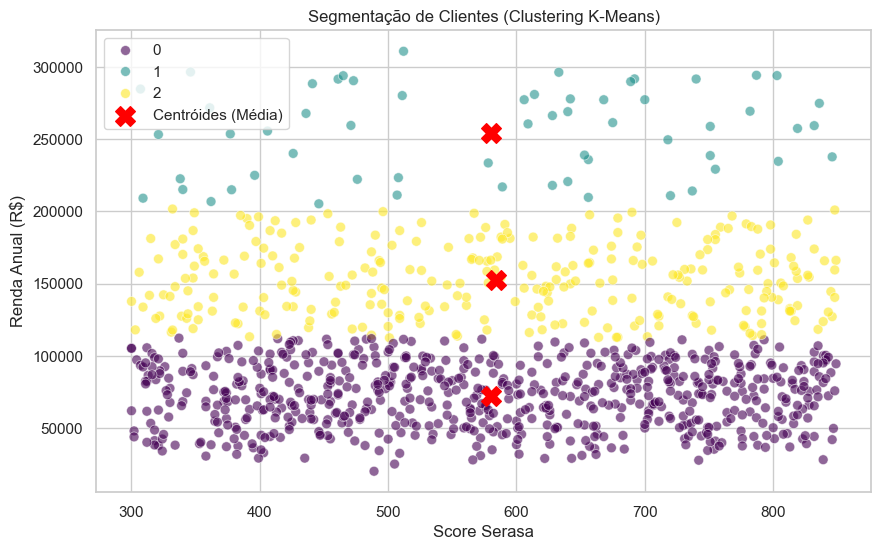

In [90]:
from sklearn.cluster import KMeans

# 1. SELEÇÃO DE DADOS
# Para visualizar em 2D, vamos usar apenas 'Renda' e 'Score'.
# A máquina vai calcular a distância entre esses dois pontos.
X_cluster = df[['renda_anual', 'score_serasa']]

# 2. DEFINIÇÃO DO MODELO
# n_clusters=3 : Pedimos para a IA encontrar 3 grupos distintos (Bronze, Prata, Ouro?)
kmeans = KMeans(n_clusters=3, random_state=42)

# 3. TREINAMENTO E PREDIÇÃO (Tudo junto)
# O método .fit_predict() treina o modelo e já diz a qual grupo cada cliente pertence (0, 1 ou 2)
df['grupo_marketing'] = kmeans.fit_predict(X_cluster)

# 4. VISUALIZAÇÃO DOS RESULTADOS
plt.figure(figsize=(10, 6))

# Plotamos cada cliente como um ponto
sns.scatterplot(
    data=df, 
    x='score_serasa', 
    y='renda_anual', 
    hue='grupo_marketing', # Colore de acordo com o grupo que a IA criou
    palette='viridis',     # Cores modernas
    s=50,                  # Tamanho da bolinha
    alpha=0.6              # Transparência para ver sobreposição
)

# Plotamos os CENTROS de cada grupo (O "Cliente Médio" daquele grupo)
centros = kmeans.cluster_centers_
plt.scatter(centros[:, 1], centros[:, 0], c='red', s=200, marker='X', label='Centróides (Média)')

plt.title("Segmentação de Clientes (Clustering K-Means)")
plt.xlabel("Score Serasa")
plt.ylabel("Renda Anual (R$)")
plt.legend()
plt.show()

### 🔎 O que a IA descobriu?

O gráfico acima nos mostra 3 regiões de cor bem definidas. Sem que a gente definisse regras, o algoritmo separou os clientes em:

* **Grupo A (Cor mais escura):** Clientes com **Baixa Renda** (independente do Score).
    * *Estratégia:* Ofertar produtos de entrada, contas digitais gratuitas e cartão universitário.
* **Grupo B (Cor intermediária):** Clientes de **Média/Alta Renda** com **Score Baixo/Médio**.
    * *Estratégia:* Este é o público com potencial de recuperação. Ofertar renegociação de dívidas ou investimentos seguros.
* **Grupo C (Cor mais clara):** Clientes de **Alta Renda** e **Score Alto**.
    * *Estratégia:* Clientes "Prime". Ofertar financiamentos imobiliários, seguros de vida e cartões Black.

Isso permite que um banco pare de mandar a mesma propaganda para todo mundo e foque no perfil exato de cada cluster.